In [13]:
import cv2

dir_names = ["gru", "cnn", "gru_cnn", "bert"]

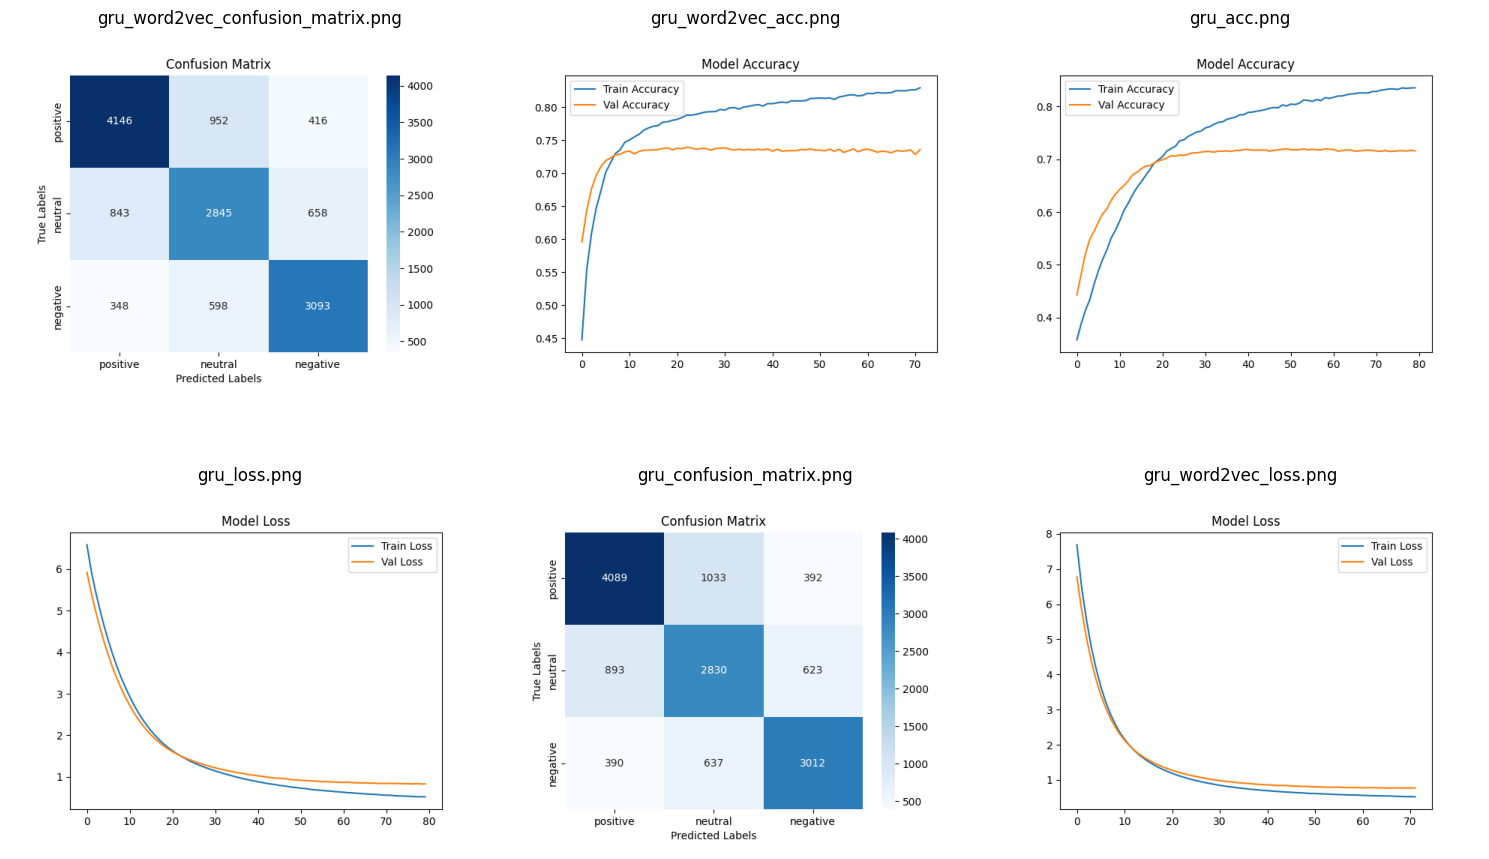

In [14]:
import os
import matplotlib.pyplot as plt

def show_images(dir_name):
    images = [file_name for file_name in os.listdir(dir_name) if file_name.endswith('.png')]
    num_images = len(images)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for ax, file_name in zip(axes, images):
        img_path = os.path.join(dir_name, file_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(file_name)
        ax.axis('off')
    
    for ax in axes[num_images:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_images("gru")

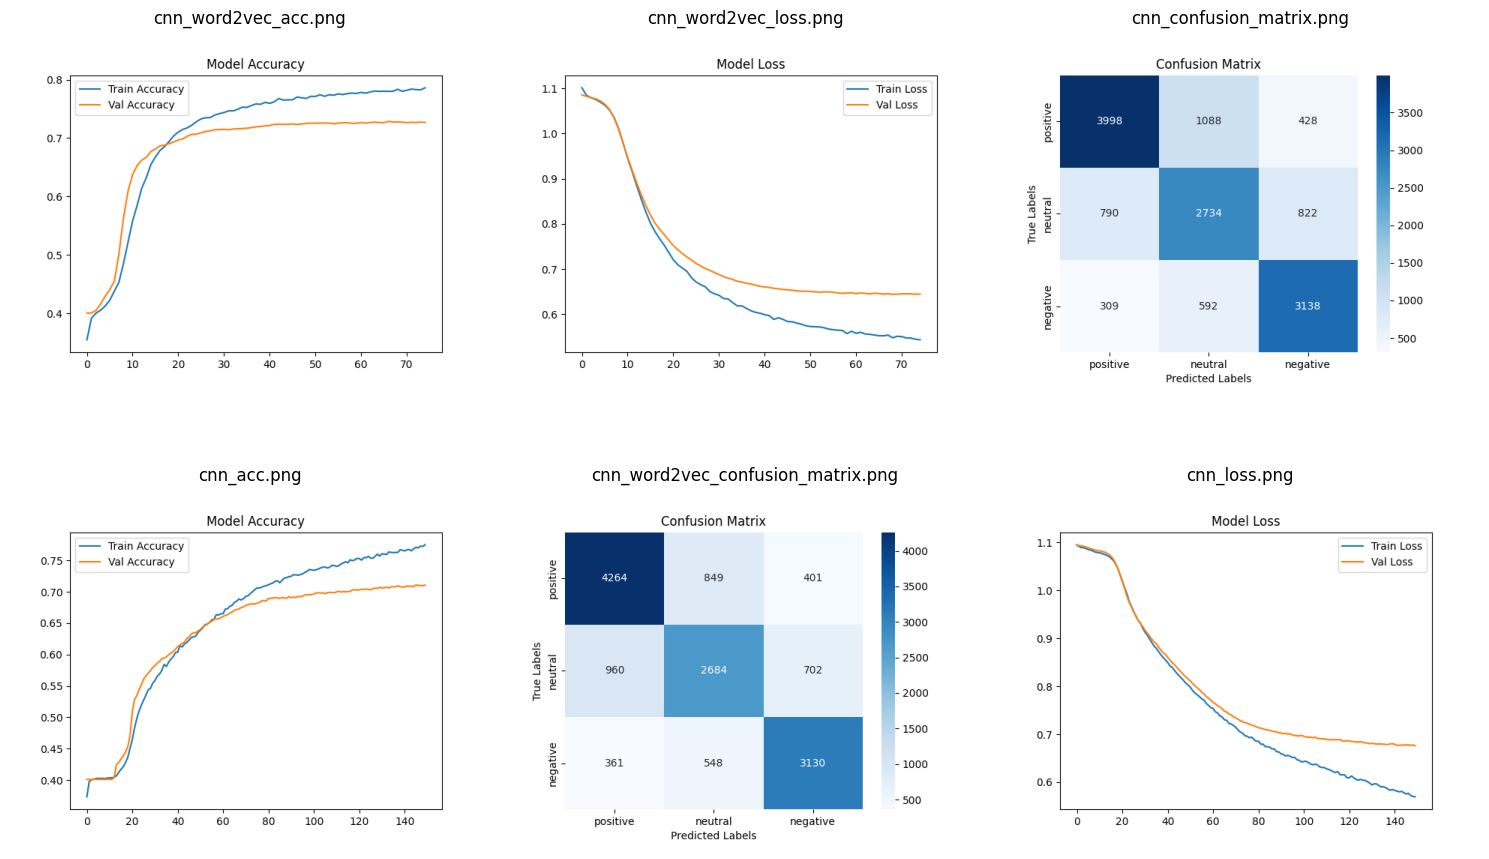

In [15]:
show_images("cnn")

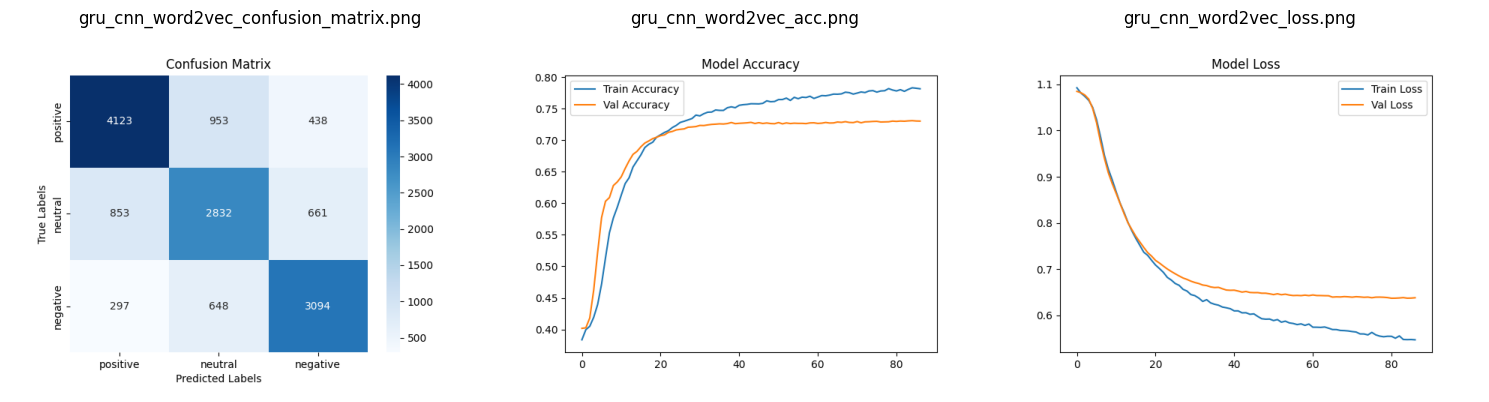

In [16]:
show_images("gru_cnn")

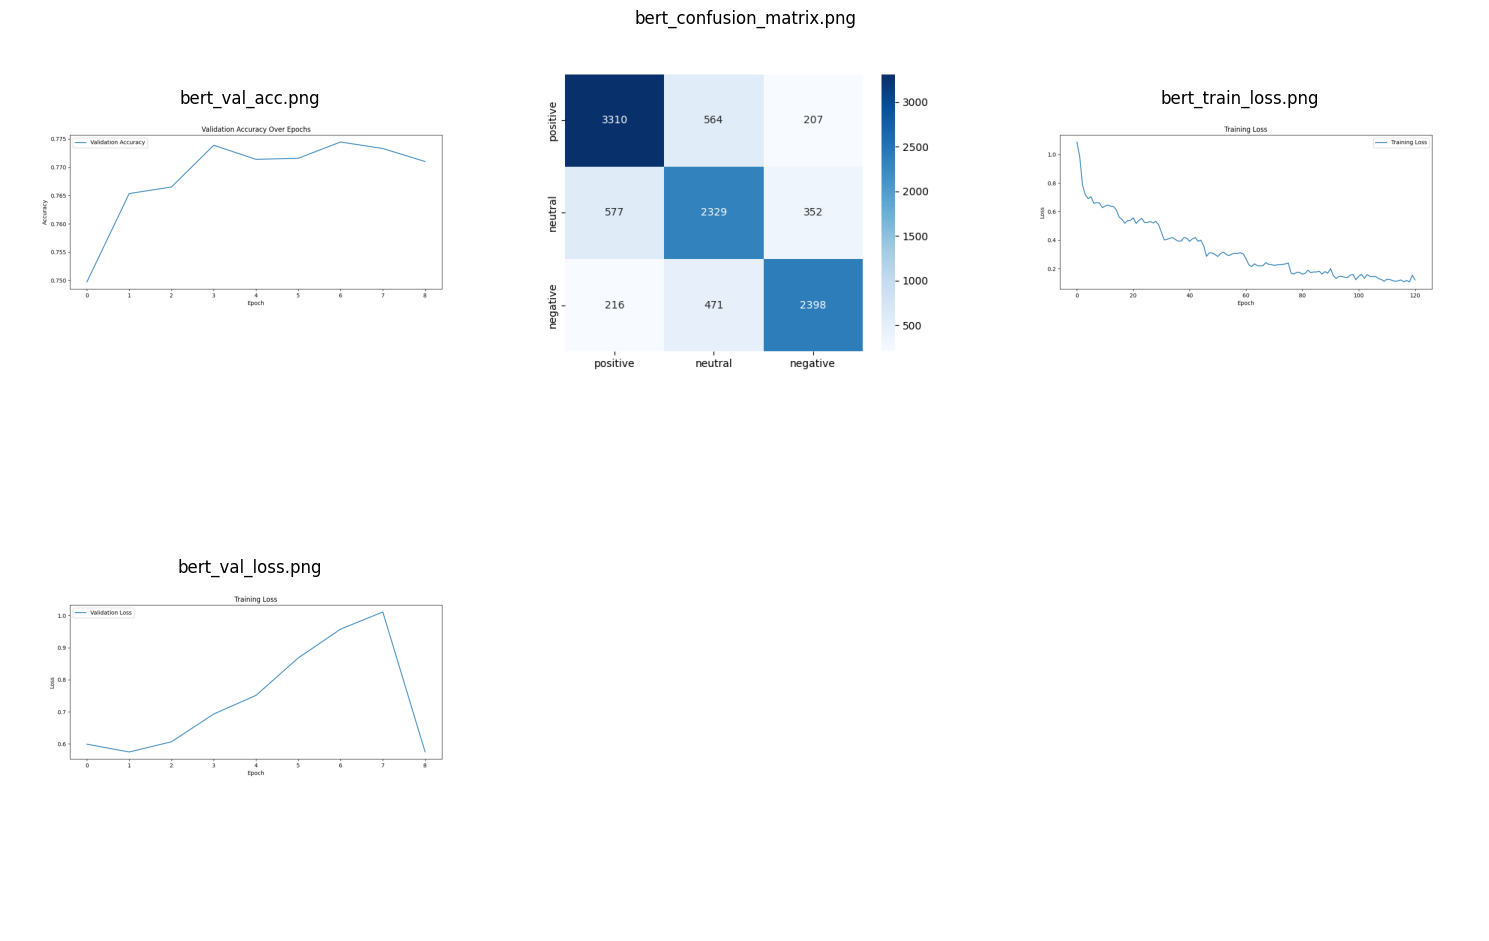

In [17]:
show_images("bert")

##### 1. Strona tytułowa
##### 2. Spis tresci
##### 3. Wstep/Wprowadznie - problem i cel projektu
##### 4. Literatura - omowienie jak podobne problemy byly rozwiazywane w literaturze
##### 5. Zbior danych - stworzenie całego datasetu ( pobranie, tlumaczenie, wybranie konkretnych rekordow, dodanie kolumn itd)
##### 6. Implementacja rozwiazania problemu - komponenty sprzetowe, oprogramowanie, szczegoly implementacji
##### 7. Rezultaty dzialania algorytmow - wykresy funkcji straty, dokladnosci, confusion matrix
##### 8 albo 7.b Dyskusja wynikow - porownanie algorytmow
##### 9 Analiza fanbase'u kierowcow
##### 10 Podsumowanie 

In [18]:
import pandas as pd
df = pd.read_json("data/bert_dataset.json")
df_wih_drivers = pd.read_json("data/2024_12_03_real.json")
mapping = {0: "negative", 1: "neutral", 2: "positive"}
df["predicted_sentiment"] = df["predicted_sentiment"].map(mapping)
df["drivers"] = df_wih_drivers["drivers"]
df.head()

,text,sentiment,predicted_sentiment,drivers
0,enjoying magnusson menace even stroll leaving ...,0,negative,[Lance Stroll]
1,isz air gray,1,neutral,[]
2,stroll troll,0,negative,[Lance Stroll]
3,know china u see sky gross,0,negative,[]
4,wish would stop repeatedly saying alonso old,0,negative,[Fernando Alonso]


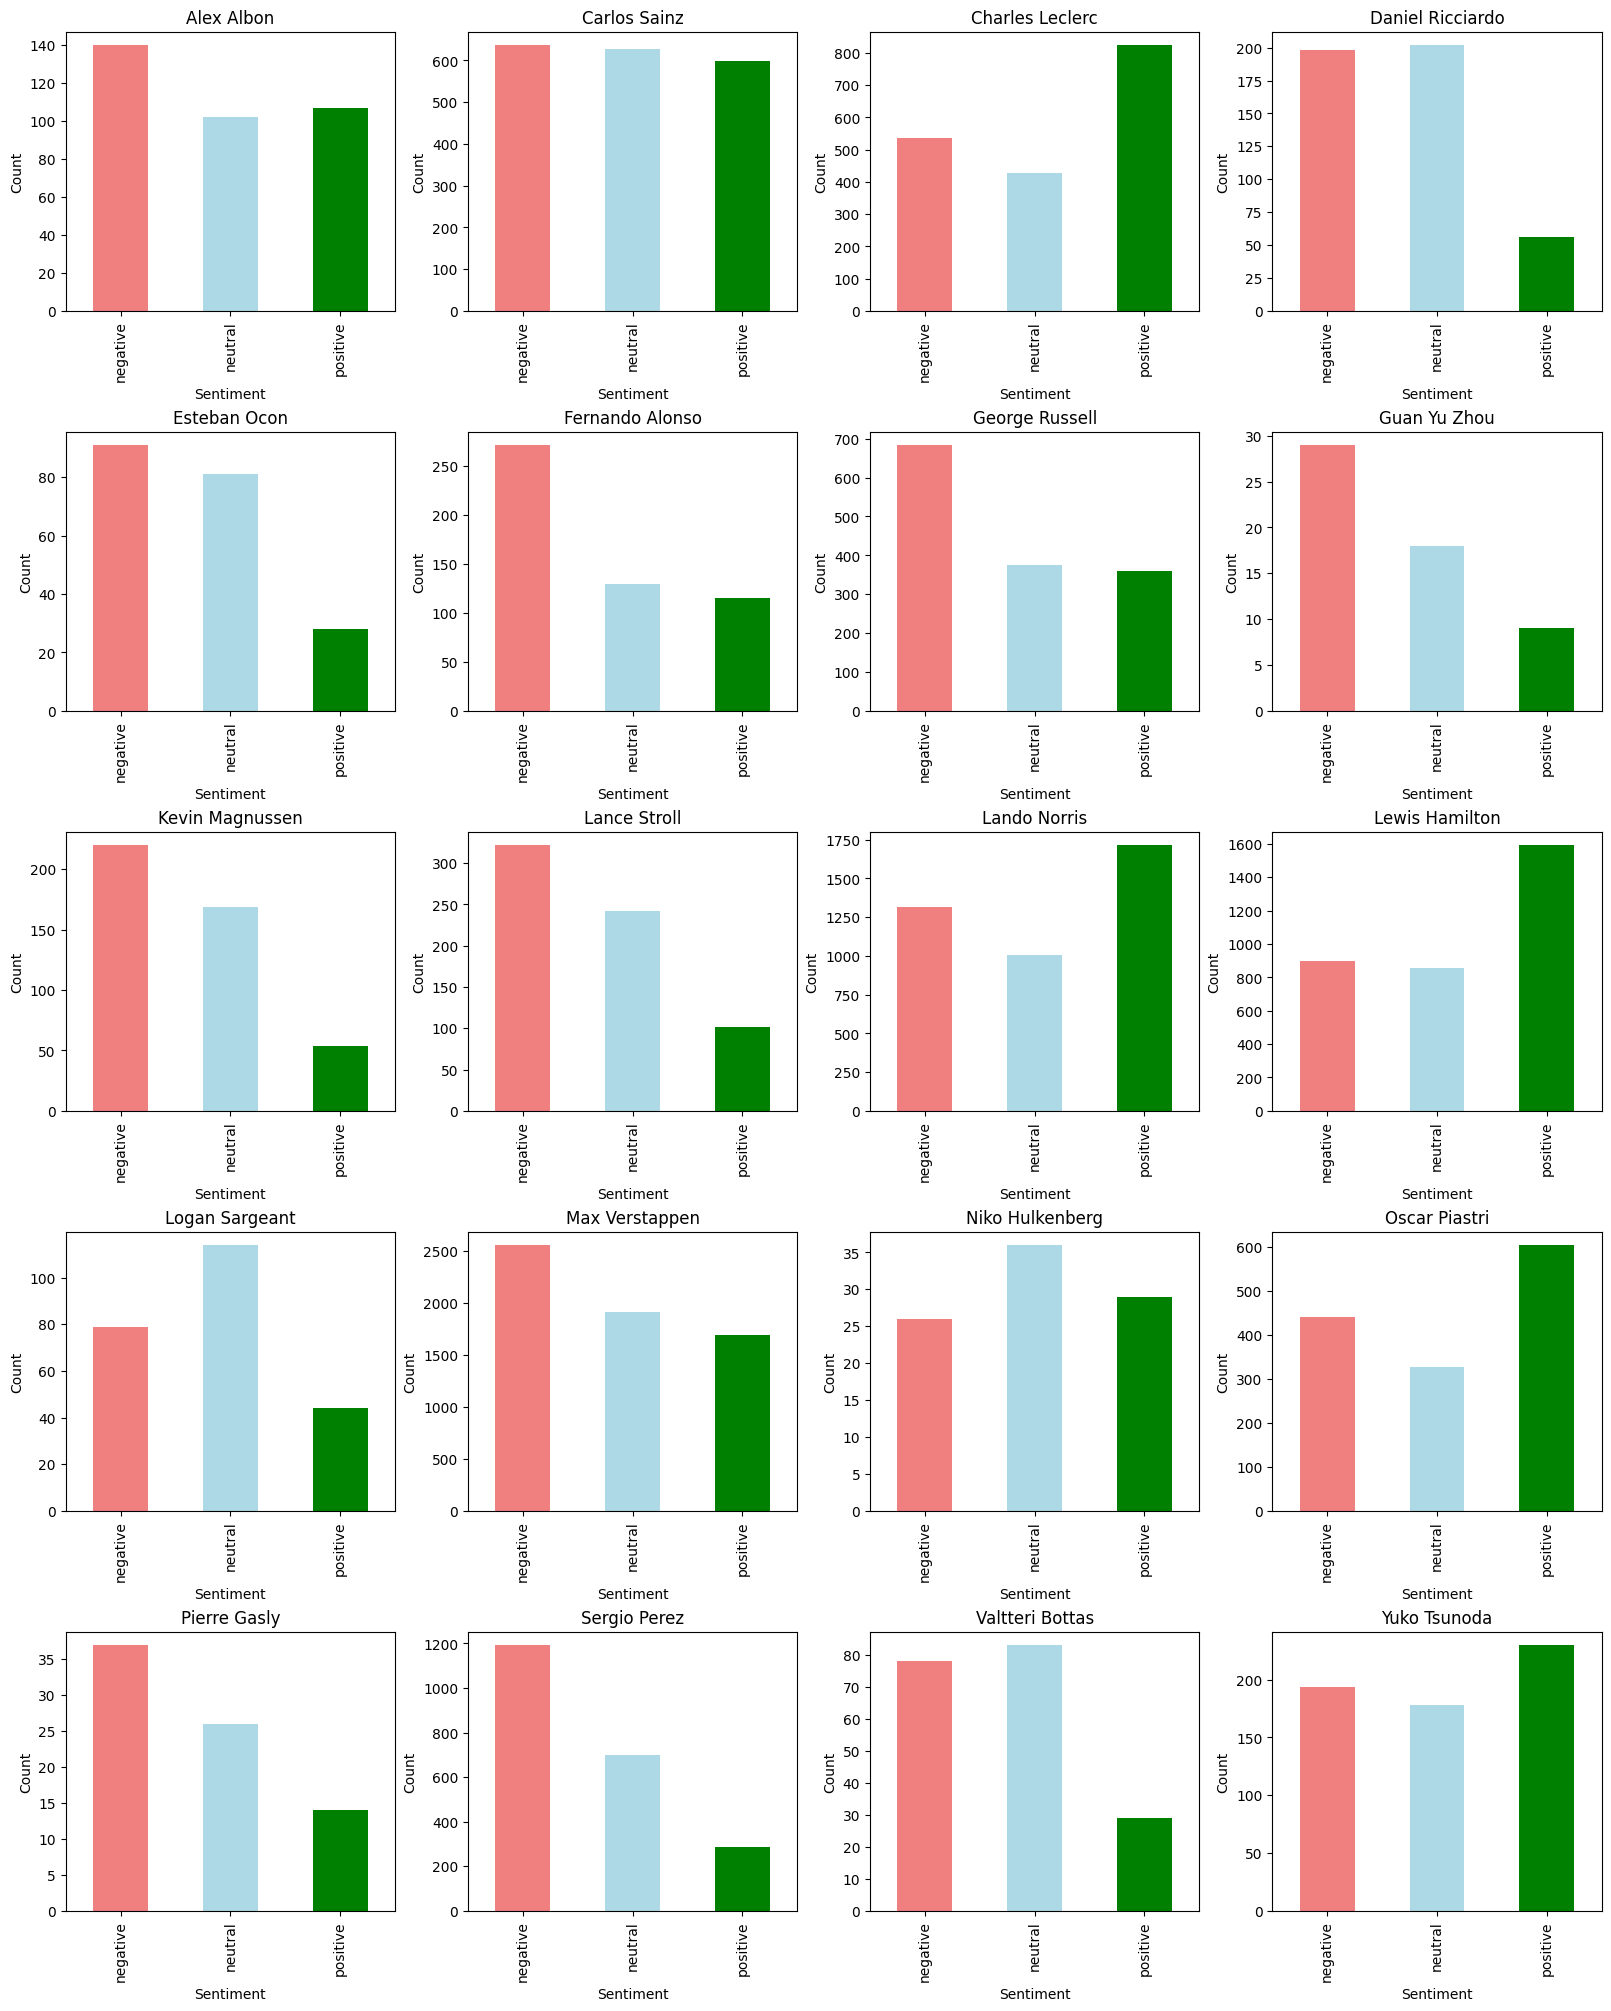

In [19]:
df_exploded = df.explode('drivers')

# Drop rows where 'drivers' is NaN
df_exploded = df_exploded.dropna(subset=['drivers'])
colors = {'negative': 'lightcoral', 'neutral': 'lightblue', 'positive': 'green'}

# Group by 'drivers' and 'predicted_sentiment' and count occurrences
driver_sentiment_counts = df_exploded.groupby(['drivers', 'predicted_sentiment']).size().unstack(fill_value=0)

# Create a figure with 4 rows and 5 columns
fig, axes = plt.subplots(5, 4, figsize=(16, 20), constrained_layout=True)
axes = axes.flatten()

# Plot each driver's sentiment counts in a separate subplot
for i, (driver, counts) in enumerate(driver_sentiment_counts.iterrows()):
    counts.plot(kind='bar', ax=axes[i], title=driver, color=[colors.get(sentiment, 'gray') for sentiment in counts.index])
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

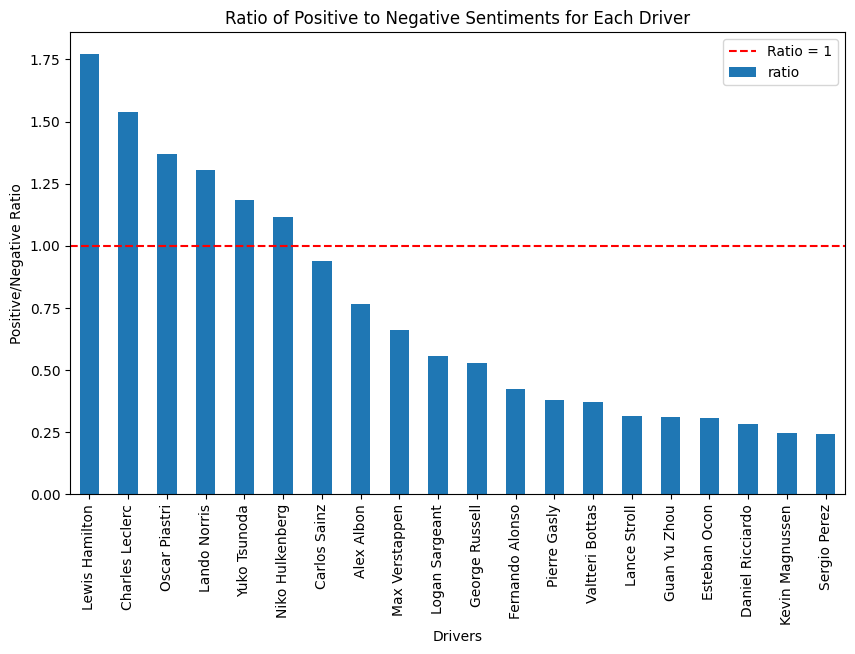

In [20]:
# Calculate the ratio of positive to negative sentiments
driver_sentiment_counts['ratio'] = driver_sentiment_counts.apply(lambda row: row.get('positive', 0) / row.get('negative', 1), axis=1)

# Sort by the ratio
sorted_driver_sentiment_counts = driver_sentiment_counts.sort_values(by='ratio', ascending=False)

# Plot the ratio
plt.figure(figsize=(10, 6))
sorted_driver_sentiment_counts['ratio'].plot(kind='bar')
plt.axhline(y=1, color='r', linestyle='--', label='Ratio = 1')
plt.title('Ratio of Positive to Negative Sentiments for Each Driver')
plt.xlabel('Drivers')
plt.ylabel('Positive/Negative Ratio')
plt.legend()
plt.show()

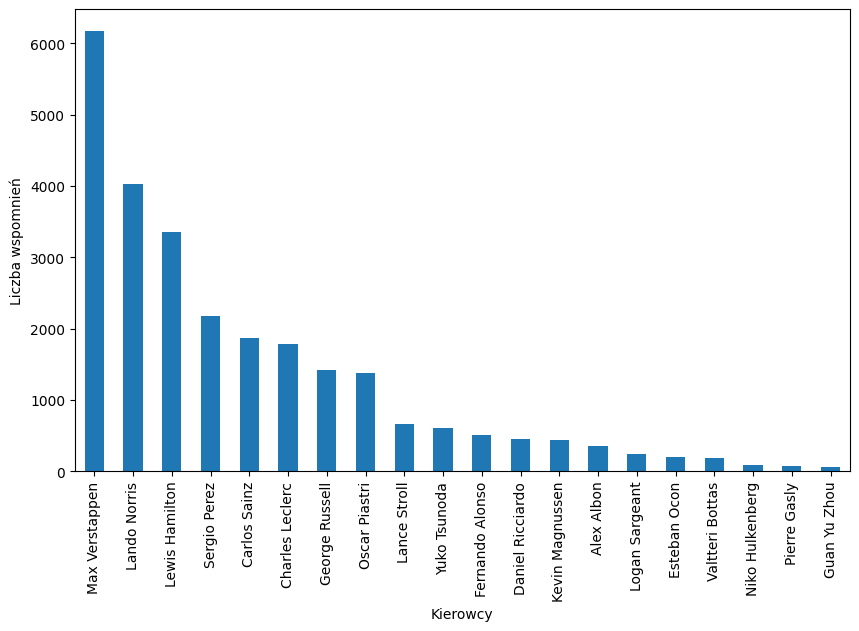

In [21]:
df_exploded = df_exploded.dropna(subset=['drivers'])

# Get the value counts of the 'drivers' column
driver_counts = df_exploded['drivers'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 6))
driver_counts.plot(kind='bar')
plt.xlabel('Kierowcy')
plt.ylabel('Liczba wspomnień')
plt.show()

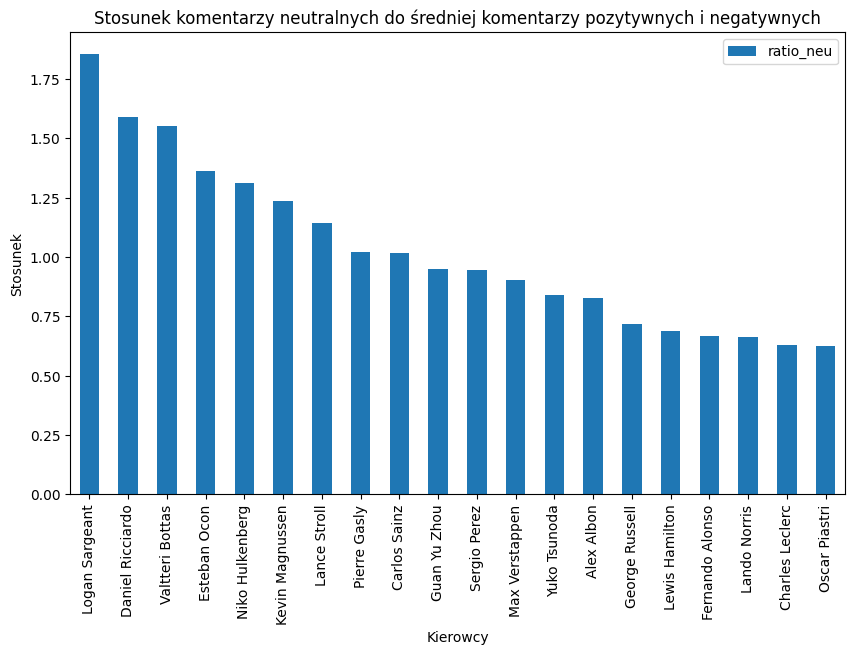

In [22]:
# Calculate the ratio of neutral comments to the average of positive and negative comments
driver_sentiment_counts['ratio_neu'] = driver_sentiment_counts.apply(
    lambda row: row.get('neutral', 0) / ((row.get('positive', 0) + row.get('negative', 0)) / 2), axis=1
)

# Sort by the ratio
sorted_driver_sentiment_counts = driver_sentiment_counts.sort_values(by='ratio_neu', ascending=False)

# Plot the ratio
plt.figure(figsize=(10, 6))
sorted_driver_sentiment_counts['ratio_neu'].plot(kind='bar')
plt.title('Stosunek komentarzy neutralnych do średniej komentarzy pozytywnych i negatywnych')
plt.xlabel('Kierowcy')
plt.ylabel('Stosunek')
plt.legend()
plt.show()

Współczynnik determinacji R^2: 0.740722650295087


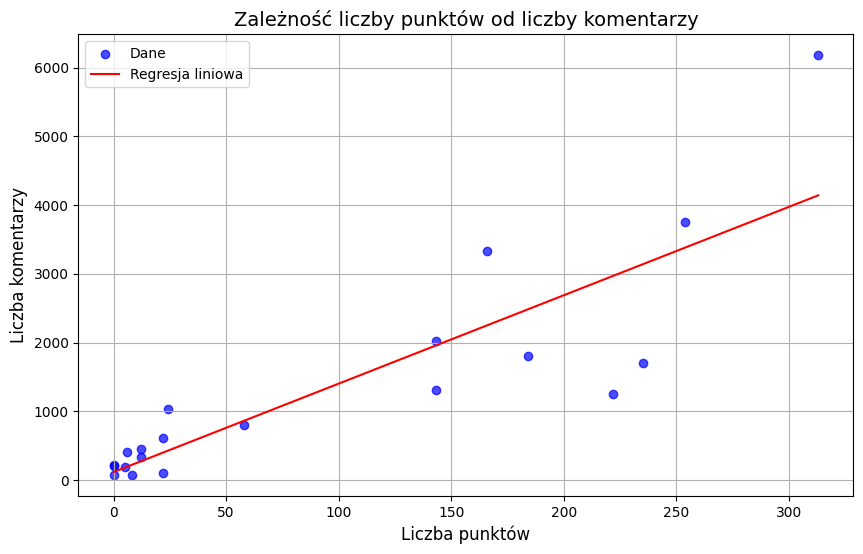

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Dane
kierowcy = [
    "Max Verstappen", "Lando Norris", "Lewis Hamilton", "Sergio Perez",
    "Carlos Sainz", "Charles Leclerc", "George Russell", "Oscar Piastri",
    "Lance Stroll", "Fernando Alonso", "Yuko Tsunoda", "Daniel Ricciardo",
    "Kevin Magnussen", "Alex Albon", "Logan Sargeant", "Valtteri Bottas",
    "Esteban Ocon", "Niko Hulkenberg", "Pierre Gasly", "Guan Yu Zhou"
]
komentarze = [
    6180, 3760, 3339, 2026, 1808, 1699, 1315, 1254, 1029, 795, 609, 457,
    403, 330, 225, 201, 188, 106, 77, 71
]
punkty_kierowcow = {
    "Max Verstappen": 313, "Lando Norris": 254, "Lewis Hamilton": 166,
    "Sergio Perez": 143, "Carlos Sainz": 184, "Charles Leclerc": 235,
    "George Russell": 143, "Oscar Piastri": 222, "Lance Stroll": 24,
    "Fernando Alonso": 58, "Yuko Tsunoda": 22, "Daniel Ricciardo": 12,
    "Kevin Magnussen": 6, "Alex Albon": 12, "Logan Sargeant": 0,
    "Valtteri Bottas": 0, "Esteban Ocon": 5, "Niko Hulkenberg": 22,
    "Pierre Gasly": 8, "Guan Yu Zhou": 0
}

punkty = [
    313, 254, 166, 143, 184, 235, 143, 222, 24, 58, 22, 12,
    6, 12, 0, 0, 5, 22, 8, 0
]


# Przygotowanie danych do regresji
X = np.array(punkty).reshape(-1, 1)
y = np.array(komentarze)

# Dopasowanie regresji liniowej
model = LinearRegression()
model.fit(X, y)

r_squared = model.score(X, y)
print(f"Współczynnik determinacji R^2: {r_squared}")

# Predykcja
x_fit = np.linspace(min(punkty), max(punkty), 500).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Wykres
plt.figure(figsize=(10, 6))
plt.scatter(punkty, komentarze, color='blue', label='Dane', alpha=0.7)
plt.plot(x_fit, y_fit, color='red', label='Regresja liniowa')
plt.title('Zależność liczby punktów od liczby komentarzy', fontsize=14)
plt.xlabel('Liczba punktów', fontsize=12)
plt.ylabel('Liczba komentarzy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
driver_sentiment_counts['punkty'] = driver_sentiment_counts.index.map(punkty_kierowcow)
driver_sentiment_counts

predicted_sentiment,negative,neutral,positive,ratio,ratio_neu,punkty
drivers,,,,,,
Alex Albon,140,102,107,0.764286,0.825911,12
Carlos Sainz,637,628,599,0.940345,1.016181,184
Charles Leclerc,536,428,825,1.539179,0.628949,235
Daniel Ricciardo,198,202,56,0.282828,1.590551,12
Esteban Ocon,91,81,28,0.307692,1.361345,5
Fernando Alonso,271,129,115,0.424354,0.668394,58
George Russell,684,374,360,0.526316,0.716475,143
Guan Yu Zhou,29,18,9,0.310345,0.947368,0
Kevin Magnussen,220,169,54,0.245455,1.233577,6


In [29]:
from scipy.stats import pearsonr
low_drivers = ["Serio Perez", "Kevin Magnussen", "Daniel Ricciardo"]


In [34]:
correlation, p_value = pearsonr(driver_sentiment_counts['ratio'], driver_sentiment_counts['punkty'])
print(f"Współczynnik korelacji Pearsona: {correlation}")
print(f"Wartość p: {p_value}")

Współczynnik korelacji Pearsona: 0.5649475916161384
Wartość p: 0.00944591020975044


In [31]:
correlation, p_value = pearsonr(driver_sentiment_counts['ratio_neu'], driver_sentiment_counts['punkty'])
print(f"Współczynnik korelacji Pearsona: {correlation}")
print(f"Wartość p: {p_value}")

Współczynnik korelacji Pearsona: -0.6159478206405712
Wartość p: 0.0038329552401723975


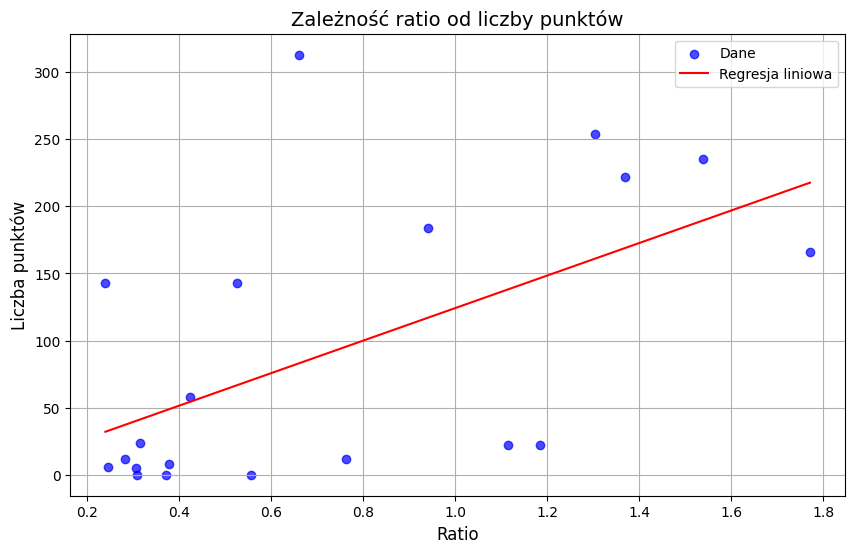

In [35]:
df = driver_sentiment_counts.copy()
X = df['ratio'].values.reshape(-1, 1)
y = df['punkty'].values

# Dopasowanie regresji liniowej
model = LinearRegression()
model.fit(X, y)

# Predykcja
x_fit = np.linspace(min(df['ratio']), max(df['ratio']), 500).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Wykres
plt.figure(figsize=(10, 6))
plt.scatter(df['ratio'], df['punkty'], color='blue', label='Dane', alpha=0.7)
plt.plot(x_fit, y_fit, color='red', label='Regresja liniowa')
plt.title('Zależność ratio od liczby punktów', fontsize=14)
plt.xlabel('Ratio', fontsize=12)
plt.ylabel('Liczba punktów', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [36]:
print(4267 + 3100 + 3357)

10724


In [37]:
print(4267 + 3100 + 3357 + 849 + 398 + 660 + 586 + 196 + 486)

13899


In [41]:
print(3100 + 660 + 586
)

4346


In [42]:
df = pd.read_json("data/bert_dataset.json")

df.head(5)

,text,sentiment,predicted_sentiment
0,enjoying magnusson menace even stroll leaving ...,0,0
1,isz air gray,1,1
2,stroll troll,0,0
3,know china u see sky gross,0,0
4,wish would stop repeatedly saying alonso old,0,0


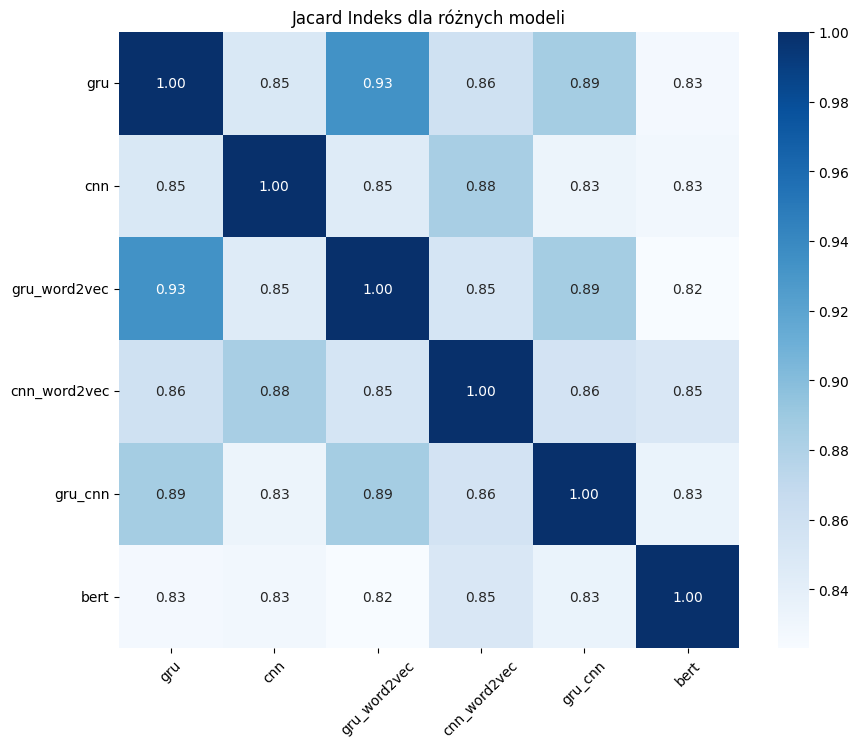

In [12]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the JSON data into a DataFrame
with open('final_dataset.json', 'r') as file:
    data = [json.loads(line) for line in file]
df = pd.DataFrame(data)
df = df.rename(columns={"sentiment": "true_sentiment"})

# Define the columns to compare
columns_to_compare = [ 'gru', 'cnn', 'gru_word2vec', 'cnn_word2vec', 'gru_cnn', 'bert']

# Initialize the matrix
matrix_size = len(columns_to_compare)
iou_matrix = np.zeros((matrix_size, matrix_size))

# Calculate IoU for each pair of columns
for i, col1 in enumerate(columns_to_compare):
    for j, col2 in enumerate(columns_to_compare):
        intersection = (df[col1] == df[col2]).sum()
        union = len(df[col1])
        iou_matrix[i, j] = intersection / union

# Create a DataFrame for better visualization
iou_df = pd.DataFrame(iou_matrix, index=columns_to_compare, columns=columns_to_compare)

# Plot the IoU matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(iou_df, annot=True, fmt=".2f", cmap="Blues")
plt.title('Jacard Indeks dla różnych modeli')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [15]:
import pandas as pd
import json

# Load the JSON data into a DataFrame
with open('final_dataset.json', 'r') as file:
    data = [json.loads(line) for line in file]
df = pd.DataFrame(data)

# Define the columns to compare
true_sentiment = df['sentiment']
model_columns = ['gru', 'cnn', 'gru_word2vec', 'cnn_word2vec', 'gru_cnn', 'bert']

# Identify rows where all models predicted the wrong sentiment
wrong_predictions = df.apply(lambda row: all(row[model] != row['sentiment'] for model in model_columns), axis=1)

# Print the rows where all models predicted the wrong sentiment
wrong_predictions_df = df[wrong_predictions]
print(wrong_predictions_df.sentiment.value_counts())
print(len(df))
wrong_predictions_df.head(15)

sentiment
1    1147
0    1117
2    1075
Name: count, dtype: int64
69493


,text,sentiment,gru,cnn,gru_word2vec,cnn_word2vec,gru_cnn,bert
39,believe alonso martin driver complete construc...,2,0,0,0,0,1,0
40,bother wasting time max verstappen wins,1,0,0,0,0,0,0
45,stroll daddy cash talents cash move,0,2,1,2,1,2,1
80,stroll must playing forza rammersport,0,1,1,1,1,1,1
85,hate max hate team dominance american love spo...,1,0,0,0,0,0,0
86,sauber casually one car,0,1,1,1,1,1,1
119,im wondering worth give watching f watch f f i...,1,0,0,0,0,0,0
124,mrbashem max fault driving superior car driver...,1,0,0,0,0,0,0
129,p boring enjoy watching racing p p,1,0,0,0,0,0,0
130,hand verstappen championship leave races,0,1,1,1,1,1,1
